In [1]:
SEED = 42
PYTORCH_PRETRAINED_BERT_CACHE = "/home/sarmishta/.pytorch_pretrained_bert"

In [39]:
import logging
import datetime

import json
import gc
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
from pytorch_pretrained_bert.modeling import BertForNextSentencePrediction
from pytorch_pretrained_bert.tokenization import BertTokenizer
# from pytorch_pretrained_bert import BertAdam
from pytorch_pretrained_bert.optimization import BertAdam, warmup_linear, SCHEDULES
from fastprogress import master_bar, progress_bar
from sklearn.model_selection import StratifiedShuffleSplit

%matplotlib notebook

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device == torch.device("cuda"):
    torch.cuda.manual_seed_all(SEED)

In [ ]:
logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger("bert")
from tensorboardX import SummaryWriter
writer = SummaryWriter('runs/{}'.format(str(datetime.datetime.now())))

## Data Preparation

In [27]:
df_full = pd.read_csv('dataset-sts/data/sts/semeval-sts/all/2015.val.tsv', 
                      sep = "\t", header = None, names = ['score', 'title', 'desc'])
df_full.title.str.len().describe()

count    750.000000
mean      72.232000
std       25.826515
min       20.000000
25%       52.000000
50%       69.000000
75%       93.000000
max      119.000000
Name: title, dtype: float64

In [28]:
df_full.head()

,score,title,desc
0,0.6,Global online #education is a key to democrati...,Op-Ed Columnist: Revolution Hits the Universities
1,2.4,Hollywood Accepts Chinese Censorship (Will Mov...,"In Hollywood Movies for China, Bureaucrats Wan..."
2,3.8,#Bloomberg: Assault weapon ban tough sell Pub...,Bloomberg: Assault weapons ban is tough sell
3,4.2,Car bomb detonates outside #Afghan intelligenc...,Powerful Car Bomb Explodes Outside Afghan Inte...
4,4.0,What's in Feinstein's gun bill - #tgdn #pjnet,What's in Feinstein's bill?


In [29]:
print(df_full.shape[0], df_full[df_full.desc.str.len() >= 10].shape[0], df_full[df_full.desc.str.len() > 200].shape[0])

750 750 0


In [30]:
df_full = df_full[df_full.desc.str.len() >= 10].copy()

In [31]:
class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, target):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.target = target

In [32]:
def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""
    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()

In [33]:
def convert_sentence_pair(score, titles, descs, max_seq_length, tokenizer):
    features = []
    for (ex_index, (score, title, desc)) in enumerate(zip(score, titles, descs)):
        tokens_a = tokenizer.tokenize(title)

        tokens_b = None
        tokens_b = tokenizer.tokenize(desc)
        # Modifies `tokens_a` and `tokens_b` in place so that the total
        # length is less than the specified length.
        # Account for [CLS], [SEP], [SEP] with "- 3"
        _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)

        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids: 0   0  0    0    0     0       0 0    1  1  1  1   1 1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids: 0   0   0   0  0     0 0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambigiously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens = ["[CLS]"] + tokens_a + ["[SEP]"]
        segment_ids = [0] * len(tokens)

        if tokens_b:
            tokens += tokens_b + ["[SEP]"]
            segment_ids += [1] * (len(tokens_b) + 1)

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        if ex_index < 5:
            logger.info("*** Example ***")
            logger.info("tokens: %s" % " ".join(
                    [str(x) for x in tokens]))
            logger.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
            logger.info("input_mask: %s" % " ".join([str(x) for x in input_mask]))
            logger.info(
                    "segment_ids: %s" % " ".join([str(x) for x in segment_ids]))

        features.append(
                InputFeatures(
                    input_ids=input_ids,
                    input_mask=input_mask,
                    segment_ids=segment_ids,
                    target=score/5.0
        ))
    return features

In [14]:
tokenizer = BertTokenizer.from_pretrained(
    "bert-base-uncased", do_lower_case=True, 
    cache_dir=PYTORCH_PRETRAINED_BERT_CACHE)

03/17/2019 10:21:10 - INFO - pytorch_pretrained_bert.tokenization -   loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/sarmishta/.pytorch_pretrained_bert/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


In [34]:
correct_pairs = convert_sentence_pair(df_full.score.tolist(), df_full.title.tolist(), df_full.desc.tolist(), max_seq_length=150, tokenizer=tokenizer)

03/17/2019 12:55:39 - INFO - bert -   *** Example ***
03/17/2019 12:55:39 - INFO - bert -   tokens: [CLS] global online # education is a key to democrat ##izing access to learning and overcoming societal ill ##s such as poverty - [SEP] op - ed columnist : revolution hits the universities [SEP]
03/17/2019 12:55:39 - INFO - bert -   input_ids: 101 3795 3784 1001 2495 2003 1037 3145 2000 7672 6026 3229 2000 4083 1998 27363 23382 5665 2015 2107 2004 5635 1011 102 6728 1011 3968 13317 1024 4329 4978 1996 5534 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
03/17/2019 12:55:39 - INFO - bert -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [35]:
len(correct_pairs)

750

## Model

In [17]:
model = BertForNextSentencePrediction.from_pretrained(
    "bert-base-uncased",
    cache_dir=PYTORCH_PRETRAINED_BERT_CACHE
).to(device)

03/17/2019 10:21:12 - INFO - pytorch_pretrained_bert.modeling -   loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at /home/sarmishta/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
03/17/2019 10:21:12 - INFO - pytorch_pretrained_bert.modeling -   extracting archive file /home/sarmishta/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir /tmp/tmp5x7ahyz9
03/17/2019 10:21:15 - INFO - pytorch_pretrained_bert.modeling -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_siz

## Eval Correct Pairs

In [36]:
BATCH_SIZE = 128
logger.info("***** Running evaluation *****")
all_input_ids = torch.tensor([f.input_ids for f in correct_pairs], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in correct_pairs], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in correct_pairs], dtype=torch.long)
eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids)
# Run prediction for full data
eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=BATCH_SIZE)

logger.info("  Num examples = %d", len(correct_pairs))
logger.info("  Batch size = %d", BATCH_SIZE)

model.eval()

res = []

mb = progress_bar(eval_dataloader)
for input_ids, input_mask, segment_ids in mb:
    input_ids = input_ids.to(device)
    input_mask = input_mask.to(device)
    segment_ids = segment_ids.to(device)

    with torch.no_grad():
        res.append(nn.functional.softmax(
            model(input_ids, segment_ids, input_mask), dim=1
        )[:, 0].detach().cpu().numpy())
        
res = np.concatenate(res)

03/17/2019 12:55:49 - INFO - bert -   ***** Running evaluation *****
03/17/2019 12:55:49 - INFO - bert -     Num examples = 750
03/17/2019 12:55:49 - INFO - bert -     Batch size = 128


In [ ]:
res[]

## Training

In [18]:
BATCH_SIZE = 16
logger.info("***** Running fine-tuning *****")
all_input_ids = torch.tensor([f.input_ids for f in correct_pairs], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in correct_pairs], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in correct_pairs], dtype=torch.long)
all_targets = torch.tensor([f.target for f in correct_pairs], dtype=torch.float)

train_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_targets)
# Run prediction for full data
train_sampler = SequentialSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

logger.info("  Num examples = %d", len(correct_pairs))
logger.info("  Batch size = %d", BATCH_SIZE)

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 1.8e-3},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
learning_rate=0.00001
optimizer = BertAdam(optimizer_grouped_parameters, lr=learning_rate)

model.train()

losses = []
num_epochs=6

writer.add_text(
    str(datetime.datetime.now()), 
    "num epochs {}, Loss:log(cosh(x)), lr={}".format(num_epochs, learning_rate)
)

mb = train_dataloader
for epoch in range(num_epochs):
#     before = [param.clone().cpu() for param in list(model.parameters())]
    i = 0
    for input_ids, input_mask, segment_ids, targets in tqdm(mb):
        input_ids = input_ids.to(device)
        input_mask = input_mask.to(device)
        segment_ids = segment_ids.to(device)
        
        result = nn.functional.softmax(
            model(input_ids, segment_ids, input_mask), dim=1
        )[:, 0]
        loss = torch.sum(torch.log(torch.cosh(targets.to(device)-result)))
        niter = epoch*len(train_dataloader)+i
        writer.add_scalar('Train/Loss', loss, niter)
        losses.append(float(loss.cpu()))
        loss.backward()
        optimizer.step()
        i+=1
#     after = [param.clone().cpu() for param in list(model.parameters())]
#     for i in range(len(before)):
#         assert(not torch.equal(before[i].data, after[i].data))
#         print(before[i].data - after[i].data)

03/17/2019 10:21:20 - INFO - bert -   ***** Running fine-tuning *****
03/17/2019 10:21:20 - INFO - bert -     Num examples = 2996
03/17/2019 10:21:20 - INFO - bert -     Batch size = 16


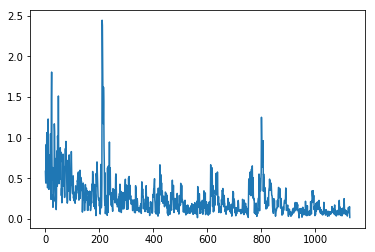

In [19]:
plt.plot(range(len(losses)), losses)

In [20]:
diffs = np.asarray(losses[0:int(len(losses)/2-1)]) - np.asarray(losses[int(len(losses)/2):-1])

In [21]:
diffs

array([ 1.87636405e-01,  2.44577587e-01,  2.99653232e-01,  6.89375669e-01,
        4.07852277e-01,  9.19805869e-01,  7.03055441e-01,  4.47327957e-01,
        3.14137429e-01,  7.03291237e-01,  1.11381619e+00,  4.94015127e-01,
        2.27220997e-01,  2.03404173e-01,  6.64015360e-01,  3.24172541e-01,
        2.96697885e-01,  5.59056416e-01,  5.92694581e-01,  9.90232058e-01,
        2.53612190e-01,  1.47950187e-01,  1.22823006e+00,  1.46132639e+00,
        7.21029088e-01,  2.59186149e-01,  2.75882751e-01,  5.00198275e-01,
       -1.76873550e-01,  2.44142950e-01,  1.97607681e-01,  1.33247167e-01,
        1.63283393e-01,  9.95694503e-01,  9.80405353e-01,  4.41665933e-01,
        5.69181263e-01,  4.29996729e-01,  1.41640387e-01,  1.19450737e-01,
       -2.29733437e-03,  1.96227409e-01,  6.41296938e-01,  2.95501471e-01,
        3.42176765e-01,  9.12658162e-01,  8.35484818e-01,  1.39742285e-01,
        8.46588016e-01,  3.99755806e-01,  1.51845336e-01,  1.83666885e-01,
        1.71248645e-01, -

In [ ]:
df_full.iloc[0]

In [83]:
def plotter(datas, labels=['score']):
    fig = plt.figure(figsize=(9, 6))
    plots = list(datas)
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']
    
    for i, (data,label) in enumerate(zip(datas, labels)):
        plots[i] = plt.hist(data, color=colors[(i%len(colors))],label=label, bins=10)
    
    plt.legend(loc='best')
    plt.title('Plotted data')
    plt.show()

<IPython.core.display.Javascript object>


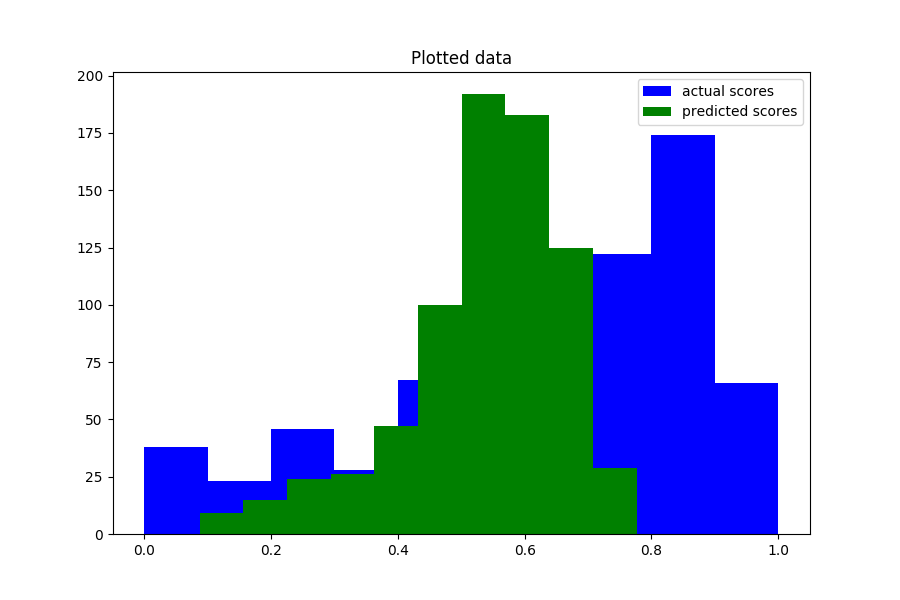

In [82]:
plotter([df_full.score/5.0, res], ['actual scores', 'predicted scores'])

In [53]:
a = plt.hist(df_full.score, bins = 10)
a

(array([ 38.,  23.,  45.,  29.,  67.,  52., 134., 122., 174.,  66.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

In [55]:
_ = plt.hist(res, bins=10)

<IPython.core.display.Javascript object>


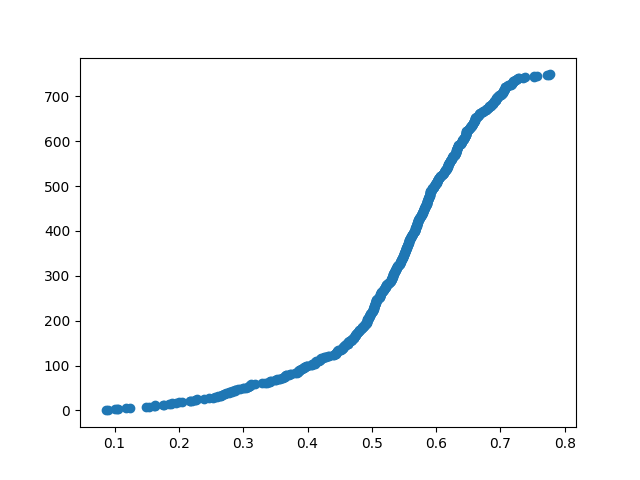

In [56]:
plt.scatter(sorted(res), range(len(res)))

In [41]:
sum(res > 0.99) / len(res), sum(res > 0.9) / len(res), sum(res < 0.5) / len(res)

(0.0, 0.0, 0.2946666666666667)

In [44]:
np.where((res < 0.8) & (res > 0.5))

(array([  1,   2,   3,   4,   5,   7,   8,   9,  13,  14,  18,  19,  20,
         21,  22,  23,  24,  25,  26,  28,  29,  30,  32,  33,  34,  36,
         38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  51,
         53,  54,  56,  57,  58,  59,  61,  63,  64,  68,  69,  70,  72,
         73,  74,  76,  77,  78,  79,  82,  83,  84,  86,  87,  88,  89,
         92,  93,  94,  96,  97,  98,  99, 101, 102, 103, 104, 107, 108,
        109, 112, 113, 114, 117, 118, 119, 121, 123, 124, 127, 128, 129,
        131, 132, 133, 134, 135, 137, 138, 139, 140, 141, 142, 143, 144,
        146, 147, 148, 149, 152, 153, 154, 156, 157, 158, 159, 162, 163,
        164, 167, 168, 169, 172, 173, 174, 177, 178, 179, 180, 182, 183,
        184, 186, 187, 188, 189, 191, 192, 193, 194, 197, 198, 199, 200,
        202, 203, 204, 206, 207, 208, 209, 211, 212, 213, 214, 217, 218,
        220, 223, 224, 228, 229, 231, 233, 234, 237, 238, 239, 242, 243,
        244, 248, 249, 251, 253, 254, 256, 258, 259

In [47]:
df_full.iloc[732], res[732], df_full.iloc[732].score/5.0

(score                                                  3.8
 title    Omo dey go tey : Opinion: Nigerians still wait...
 desc                    Nigeria waits for 'African Spring'
 Name: 732, dtype: object, 0.66122913, 0.76)

In [43]:
np.where(res < 0.5)

(array([  0,   6,  10,  11,  12,  15,  16,  17,  27,  31,  35,  37,  50,
         52,  55,  60,  62,  65,  66,  67,  71,  75,  80,  81,  85,  90,
         91,  95, 100, 105, 106, 110, 111, 115, 116, 120, 122, 125, 126,
        130, 136, 145, 150, 151, 155, 160, 161, 165, 166, 170, 171, 175,
        176, 181, 185, 190, 195, 196, 201, 205, 210, 215, 216, 219, 221,
        222, 225, 226, 227, 230, 232, 235, 236, 240, 241, 245, 246, 247,
        250, 252, 255, 257, 260, 261, 265, 266, 270, 275, 276, 283, 285,
        291, 293, 295, 296, 297, 300, 302, 305, 306, 311, 315, 316, 320,
        325, 330, 335, 337, 340, 345, 350, 351, 355, 360, 365, 375, 380,
        385, 386, 390, 391, 395, 397, 400, 405, 410, 415, 417, 420, 431,
        436, 440, 445, 446, 450, 451, 452, 454, 455, 456, 465, 480, 490,
        495, 496, 505, 507, 515, 516, 520, 525, 526, 530, 538, 540, 545,
        546, 550, 552, 555, 561, 566, 570, 580, 583, 585, 586, 590, 591,
        595, 596, 600, 601, 610, 611, 614, 615, 620

## Eval Correct Pairs

In [ ]:
BATCH_SIZE = 128
logger.info("***** Running evaluation *****")
all_input_ids = torch.tensor([f.input_ids for f in correct_pairs], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in correct_pairs], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in correct_pairs], dtype=torch.long)
eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids)
# Run prediction for full data
eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=BATCH_SIZE)

logger.info("  Num examples = %d", len(correct_pairs))
logger.info("  Batch size = %d", BATCH_SIZE)

model.eval()

res = []

mb = progress_bar(eval_dataloader)
for input_ids, input_mask, segment_ids in mb:
    input_ids = input_ids.to(device)
    input_mask = input_mask.to(device)
    segment_ids = segment_ids.to(device)

    with torch.no_grad():
        res.append(nn.functional.softmax(
            model(input_ids, segment_ids, input_mask), dim=1
        )[:, 0].detach().cpu().numpy())
        
res = np.concatenate(res)

In [ ]:
idx = 0
df_full.iloc[idx].title, df_full.iloc[idx].desc

## Find similar entries

In [ ]:
df_full.iloc[102].to_dict()

In [24]:
idx = 102
sentence_pairs = convert_sentence_pair(
    [df_full.iloc[idx]["title"]] * df_full.shape[0], 
    df_full.desc.tolist(), max_seq_length=200, tokenizer=tokenizer)

TypeError: convert_sentence_pair() missing 1 required positional argument: 'descs'

In [ ]:
BATCH_SIZE = 128
logger.info("***** Running evaluation *****")
all_input_ids = torch.tensor([f.input_ids for f in sentence_pairs], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in sentence_pairs], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in sentence_pairs], dtype=torch.long)
eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids)
# Run prediction for full data
eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=BATCH_SIZE)

logger.info("  Num examples = %d", len(correct_pairs))
logger.info("  Batch size = %d", BATCH_SIZE)

model.eval()

res = []

mb = progress_bar(eval_dataloader)
for input_ids, input_mask, segment_ids in mb:
    input_ids = input_ids.to(device)
    input_mask = input_mask.to(device)
    segment_ids = segment_ids.to(device)

    with torch.no_grad():
        res.append(nn.functional.softmax(
            model(input_ids, segment_ids, input_mask), dim=1
        )[:, 0].detach().cpu().numpy())
        
res = np.concatenate(res)

In [ ]:
_ = plt.hist(res, bins=100)

In [ ]:
best_matches = np.argsort(res)[::-1][:10]
best_matches

In [ ]:
from pprint import pprint
for _, row in df_full.iloc[best_matches].iterrows():
    pprint(row.to_dict())